In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root_path = "/content/drive/MyDrive/data"

In [3]:
root_path = root_path + "/"

In [4]:
!pip install transformers
!pip install evaluate
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install -U pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
! pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd

from datasets import load_dataset
from datasets import ClassLabel, Value

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_scheduler

import evaluate

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
import json
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.__version__

'0.12.1'

In [9]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
device

device(type='cpu')

In [10]:
train_file_path = root_path+'train.jsonl'
val_file_path = root_path+'validation.jsonl'

train_classification_data_custom_bert_lstm_file_path = root_path+'train_classification_data_custom_bert_lstm.jsonl'
undersampled_train_classification_data_custom_bert_lstm_file_path = root_path+'undersampled_train_classification_data_custom_bert_lstm.jsonl'
val_classification_data_custom_bert_lstm_file_path = root_path+'val_classification_data_custom_bert_lstm.jsonl'

model_path = root_path+'custom_bert_lstm_undersampled_model.pth'

train_qa_data_all_file_path = root_path+'qa/train_qa_data_all.json'
val_qa_data_all_file_path = root_path+'qa/val_qa_data_all.json'

val_qa_data_custom_bert_lstm_top_4_file_path = root_path+'qa/val_qa_data_custom_bert_lstm_top_4.json'
val_qa_data_custom_bert_lstm_top_10_file_path = root_path+'qa/val_qa_data_custom_bert_lstm_top_10.json'
val_qa_data_oracle_file_path = root_path+'qa/val_qa_data_oracle.json'



In [11]:
# data preprocessing

def load_data(file_path):
  with open(file_path, 'r') as f:
    sentences = [json.loads(sentence.rstrip()) for sentence in f.readlines()]
    filtered_sentences = [{_key: _value for _key, _value in _sentence.items() if _key in ['uuid', 'postText', 'targetTitle', 'targetParagraphs', 'spoiler', 'spoilerPositions', 'tags']} for _sentence in sentences]
    return filtered_sentences

In [12]:
# load data

train_data = load_data(train_file_path)
val_data = load_data(val_file_path)

In [13]:
# reformat data and add proper spoiler positions using simple heuristics observed during data analysis

def reformat_spoiler_positions(data):
    reformatted_data = []
    ignore_idx = []

    for _idx, _sentence in enumerate(data):

        spoiler_positions = _sentence['spoilerPositions']
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['targetParagraphs']
        all_target_paragraphs = [target_title] + target_paragraphs

        refactored_spoiler_positions = {}
        for _spoiler_passage_positions in spoiler_positions:
            if len(_spoiler_passage_positions) != 2:
                print('ignoring idx: {}'.format(_idx))
                ignore_idx.append(_idx)
                break

            _start_pos = _spoiler_passage_positions[0][1]
            _start_pos_passage = _spoiler_passage_positions[0][0]

            _end_pos = _spoiler_passage_positions[1][1]
            _end_pos_passage = _spoiler_passage_positions[1][0]

            if _start_pos_passage != _end_pos_passage:

                if _start_pos_passage == -1:
                    negative_mismatch_idx.append(_idx)

                _refactored_spoiler_positions = {}

                for _passage_idx in range(_start_pos_passage, _end_pos_passage):

                    if _passage_idx == _start_pos_passage:
                        _start = _start_pos - len(' '.join(target_paragraphs[:_passage_idx])) - 1
                        _refactored_spoiler_positions[_passage_idx + 1] = [
                            (_start if _start == 0 else _start - 1,
                             None)]

                    elif _passage_idx == _end_pos_passage:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, _end_pos - 1 - len(' '.join(target_paragraphs[:_passage_idx])))]

                    else:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, None)]

                for _key, _value in _refactored_spoiler_positions.items():
                    if _key not in refactored_spoiler_positions:
                        refactored_spoiler_positions[_key] = _value 
                    else:
                        refactored_spoiler_positions[_key].extend(_value)

            else:
                if _start_pos_passage + 1 not in refactored_spoiler_positions:
                    refactored_spoiler_positions[_start_pos_passage + 1] = [(_start_pos, _end_pos)]
                else:
                    refactored_spoiler_positions[_start_pos_passage + 1].append((_start_pos, _end_pos))

        reformatted_data.append({**_sentence, 'allTargetParagraphs': all_target_paragraphs, 'refactoredSpoilerPositions': refactored_spoiler_positions})
        
    return reformatted_data, ignore_idx


In [14]:
# reformat data with proper spoiler positions

train_data_reformatted, _ = reformat_spoiler_positions(data=train_data)
val_data_reformatted, _ = reformat_spoiler_positions(data=val_data)

ignoring idx: 546


In [15]:
# remove data datapoints where the spoiler positions don't match the actual spoiler text

def remove_bad_matches_data(data):

    exact_match_bad_annotations = []
    exact_match_bad_annotations_ids = []
    not_found_exact_matchs = {}

    clean_data = []

    for _idx, _sentence in enumerate(data):
        for _key in _sentence['refactoredSpoilerPositions'].keys():
            for _value_idx in range(len(_sentence['refactoredSpoilerPositions'][_key])):
        
                _start_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][0]
                _end_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][1]

                if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] not in _sentence['spoiler'] and not any(True for _spoiler in _sentence['spoiler'] if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] in _spoiler):
                    exact_match_bad_annotations.append(_sentence)
                    exact_match_bad_annotations_ids.append(_idx)
                    if _idx not in not_found_exact_matchs:
                        not_found_exact_matchs[_idx] = [_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos]]
                    else:
                        not_found_exact_matchs[_idx].append(_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos])
                else:
                    clean_data.append(_sentence)
  
    return clean_data, exact_match_bad_annotations_ids, not_found_exact_matchs



In [16]:
# clean data

clean_train_data, _, not_found_spoilers_train = remove_bad_matches_data(data=train_data_reformatted)
clean_val_data, _, not_found_spoilers_val = remove_bad_matches_data(data=val_data_reformatted)

In [17]:
# flatten nested data.
# change_multi true will relable the multi-spoiler data as either phrase or passage depending on
# the length of spoiler.

def flatten_data(data, change_multi=True):
    flattened_data = []
    for _sentence in data:

        uuid = _sentence['uuid']
        post = ' '.join(_sentence['postText'])
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['allTargetParagraphs']
        spoiler_positions = _sentence['refactoredSpoilerPositions']
        spoiler_type = _sentence['tags']

        for _idx, _target_paragraph in enumerate(target_paragraphs):
            _spoiler_pos = spoiler_positions.get(_idx, None)

            if not change_multi and spoiler_type[0] != 'multi':
                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': spoiler_type[0] if _spoiler_pos else None,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

            else:
                _spoiler_type = None
                if _spoiler_pos:
                    if spoiler_type[0] != 'multi':
                        _spoiler_type = spoiler_type[0]
                    else:
                        _spoiler_texts = ([_target_paragraph[__spoiler_pos[0]: __spoiler_pos[1]] for __spoiler_pos in _spoiler_pos])
                        _max_length = max([len(_x.split(' ')) for _x in _spoiler_texts])
                        if _max_length <=5:
                            _spoiler_type = 'phrase'
                        else:
                            _spoiler_type = 'passage'

                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': _spoiler_type,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

    return flattened_data

In [18]:
# flattened data

flattened_train_data = flatten_data(data=clean_train_data, change_multi=True)
flattened_val_data = flatten_data(data=clean_val_data, change_multi=True)

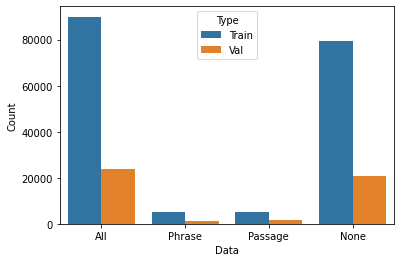

In [19]:
# flattened data distribution

distribution_df = pd.DataFrame(columns=["Data", "Type", "Count"], data={
    "Data":['All', 'All', 'Phrase', 'Phrase', 'Passage', 'Passage', 'None', 'None'],
    "Count": [len(flattened_train_data),
              len(flattened_val_data),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == None]),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == None])],
    "Type": ['Train', 'Val', 'Train', 'Val', 'Train', 'Val', 'Train', 'Val']
})
sns.barplot(distribution_df, x="Data" , y="Count", hue="Type")


In [20]:
# prepare classification data for bert + lstm

def prepare_classification_data_for_custom_bert_lstm(flattened_data, undersample_ratio=1.0):
    clasification_data = []
    undersampled_data = []
    
    for _x in flattened_data:
        _data = {
            'uuid': _x['uuid'],
            'targetParagraphId': _x['targetParagraphId'],
            'text': _x['postText'] + ' ' + _x['targetParagraph'],
            'labels': [1., 0., 0.] if not _x['spoilerType'] else [0., 1., 0.] if _x['spoilerType'] == 'phrase' else [0., 0., 1.],
            # **_x
          }
        clasification_data.append(_data)
    
    none_data = [_data for _data in clasification_data if _data['labels'][0]]
    len_undersampled = int(len(none_data)*undersample_ratio)
    for _data in np.random.choice(none_data, size=len_undersampled, replace=False):
        undersampled_data.append(_data)
    for _x in clasification_data:
        if _x['labels'][1] or _x['labels'][2]:
            undersampled_data.append(_x)

    
    return undersampled_data

In [21]:
# create data for bert + lstm

classification_train_data_custom_bert_lstm = prepare_classification_data_for_custom_bert_lstm(flattened_data=flattened_train_data)
undersampled_classification_train_data_custom_bert_lstm = prepare_classification_data_for_custom_bert_lstm(flattened_data=flattened_train_data, undersample_ratio=0.3)
classification_val_data_custom_bert_lstm = prepare_classification_data_for_custom_bert_lstm(flattened_data=flattened_val_data)


In [22]:
def write_classification_data(classification_data, out_file_path):
    with open(out_file_path, 'w') as outfile:
        for entry in classification_data:
            json.dump(entry, outfile)
            outfile.write('\n')


In [23]:
# write data for bert + lstm

# write train classification data
write_classification_data(classification_data=classification_train_data_custom_bert_lstm, out_file_path=train_classification_data_custom_bert_lstm_file_path)

# write undersampled train classification data
write_classification_data(classification_data=undersampled_classification_train_data_custom_bert_lstm, out_file_path=undersampled_train_classification_data_custom_bert_lstm_file_path)

# write val classification data
write_classification_data(classification_data=classification_val_data_custom_bert_lstm, out_file_path=val_classification_data_custom_bert_lstm_file_path)


In [24]:
# load hf dataset
hf_dataset_train = load_dataset('json', data_files=undersampled_train_classification_data_custom_bert_lstm_file_path)
hf_dataset_val = load_dataset('json', data_files=val_classification_data_custom_bert_lstm_file_path)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-4d889595ba3d07c8/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-54b8371e7981abeb/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
# model type

model_type = "bert-base-uncased"


In [26]:
# load tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_type)

In [27]:
# tokenize dataset

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_hf_dataset_train = hf_dataset_train.map(tokenize_function, batched=True)
tokenized_hf_dataset_val = hf_dataset_val.map(tokenize_function, batched=True)

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

In [ ]:
# remove unnecessary text columns

tokenized_hf_dataset_train = tokenized_hf_dataset_train.remove_columns(["text"])
tokenized_hf_dataset_val = tokenized_hf_dataset_val.remove_columns(["text"])

In [ ]:
# to torch format
tokenized_hf_dataset_train.set_format("torch")
tokenized_hf_dataset_val.set_format("torch")

In [ ]:
# dataset

tokenized_hf_dataset_train, tokenized_hf_dataset_val

In [ ]:
# dataloader

batch_size = 32
train_dataloader = DataLoader(tokenized_hf_dataset_train['train'], shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(tokenized_hf_dataset_val['train'], batch_size=batch_size)


In [ ]:
class bert_lstm(nn.Module):
    def __init__(self, num_labels, hidden_dim, n_layers, bidirectional=True, drop_prob=0.1, bertpath = "bert-base-uncased"):
        super(bert_lstm, self).__init__()
 
        self.output_size = num_labels
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.drop_prob = drop_prob
        self.bertpath = bertpath
        
        self.bert=BertModel.from_pretrained(self.bertpath)
        for param in self.bert.parameters():
            param.requires_grad = True
        
        self.bert_hidden_size = self.bert.config.hidden_size

        
        # LSTM layers
        self.lstm = nn.LSTM(self.bert_hidden_size, self.hidden_dim, self.n_layers, bidirectional=self.bidirectional, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(self.drop_prob)
        
        # linear
        if bidirectional:
            self.fc = nn.Linear(self.hidden_dim*2, self.output_size)
        else:
            self.fc = nn.Linear(self.hidden_dim, self.output_size)
 
    def forward(self, x):
        # print('x: {}'.format(x))
        # print('x: {}'.format(x['input_ids'].shape))
        # print('batch size: {}'.format(x['input_ids'].size(0)))
        
        batch_size = x['input_ids'].size(0)
        hidden = self.init_hidden(batch_size=batch_size)
        x=self.bert(**x)[0]        
        _, (hidden_last, _) = self.lstm(x, hidden)        
        if self.bidirectional:
            hidden_last_L=hidden_last[-2]
            hidden_last_R=hidden_last[-1]
            hidden_last_out=torch.cat([hidden_last_L,hidden_last_R],dim=-1)
        else:
            hidden_last_out=hidden_last[-1]   #[32, 384]
            
        out = self.dropout(hidden_last_out)
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        if self.bidirectional:
            num_directions = 2
        else:
            num_directions = 1
        
        h_0 = nn.Parameter(torch.randn(self.n_layers * num_directions, batch_size, self.hidden_dim).type(torch.FloatTensor).to(device), requires_grad=True)
        c_0 = nn.Parameter(torch.randn(self.n_layers * num_directions, batch_size, self.hidden_dim).type(torch.FloatTensor).to(device), requires_grad=True)
        
        return (h_0, c_0)

In [ ]:
# load model
model = bert_lstm(num_labels=3, hidden_dim=256, n_layers=1, bidirectional=True, drop_prob=0.1, bertpath=model_type)


In [ ]:
# load optimizer

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
# define loss function

loss_function = nn.CrossEntropyLoss()


In [ ]:
# define scheduler

num_epochs = 6
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
# push model to device
model = model.to(device)

In [ ]:
# clear any caches

torch.cuda.empty_cache()

In [ ]:
# run training

train_loss_history = []
val_loss_history = []
phrase_f1 = []
passage_f1 = []
none_f1 = []
macro_f1 = []
max_macro_f1 = 0.

for epoch in range(num_epochs):

    train_running_loss_history = []
    val_running_loss_history = []
    running_loss = 0.
    batch_wise_labels = []
    batch_wise_predictions = []
    
    print('epoch: {}'.format(epoch))
    print('train')

    model.train()

    for _idx, batch in enumerate(train_dataloader):

        batch = {k: v.to(device) for k, v in batch.items() if k not in ['uuid', 'targetParagraphId']}

        outputs = model({k: v for k, v in batch.items() if k != 'labels'})
        
        loss = loss_function(outputs.view(-1).to(device), batch['labels'].view(-1).to(device))
        loss_value = loss.item()

        running_loss += (loss_value - running_loss) / (_idx + 1)
        train_running_loss_history.append(running_loss)
        
        loss.backward()

        optimizer.step()
        lr_scheduler.step()

        optimizer.zero_grad()
        
        logits = F.softmax(outputs, dim=-1)

        predictions = torch.argmax(logits, dim=-1)

        batch_wise_labels.append([_x.index(1.0) for _x in batch['labels'].tolist()])
        batch_wise_predictions.append(predictions.tolist())

    train_loss_history.append(np.mean(train_running_loss_history))
    all_labels = list(chain.from_iterable(batch_wise_labels))
    all_predictions = list(chain.from_iterable(batch_wise_predictions))
    
    print('Train Metrics')
    print(classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage']))

    running_loss = 0.
    batch_wise_uuids = []
    batch_wise_labels = []
    batch_wise_predictions = []
    batch_wise_logits = []

    print('eval')
    model.eval()

    for _idx, batch in enumerate(eval_dataloader):

        batch = {k: v.to(device) for k, v in batch.items() if k not in ['uuid', 'targetParagraphId']}

        with torch.no_grad():
            
            outputs = model({k: v for k, v in batch.items() if k != 'labels'})

            loss = loss_function(outputs.view(-1).to(device), batch['labels'].view(-1).to(device))
            loss_value = loss.item()

            running_loss += (loss_value - running_loss) / (_idx + 1)
            val_running_loss_history.append(running_loss)

            logits = F.softmax(outputs, dim=-1)

            predictions = torch.argmax(logits, dim=-1)

            batch_wise_labels.append([_x.index(1.0) for _x in batch['labels'].tolist()])
            batch_wise_predictions.append(predictions.tolist())


    mean_loss = np.mean(val_running_loss_history)
    val_loss_history.append(mean_loss)
    all_labels = list(chain.from_iterable(batch_wise_labels))
    all_predictions = list(chain.from_iterable(batch_wise_predictions))
    
    print('Val Metrics')
    print(classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage']))
    _classification_report = classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage'], output_dict=True)
    
    phrase_f1.append(_classification_report['phrase']['f1-score'])
    passage_f1.append(_classification_report['passage']['f1-score'])
    none_f1.append(_classification_report['none']['f1-score'])
    macro_f1.append(_classification_report['macro avg']['f1-score'])
    
    if(macro_f1[-1]>max_macro_f1):
        print()
        print ('Saving best model...')
        max_macro_f1=macro_f1[-1]
        torch.save(model.state_dict(), model_path)



In [ ]:
train_epoch_idx = range(len(train_loss_history))
val_epoch_idx = range(len(val_loss_history))

losses_df = pd.DataFrame(columns=["Epoch", "Loss", "Type"], data={"Epoch": [_i for _i in train_epoch_idx] + [_i for _i in val_epoch_idx], "Loss": train_loss_history + val_loss_history, "Type": ["Train Loss"]*len(train_epoch_idx) + ["Validation Loss"]*len(val_epoch_idx)})
sns.lineplot(losses_df, x="Epoch" , y="Loss", hue="Type")

In [ ]:
train_epoch_idx = range(len(phrase_f1))

f1_df = pd.DataFrame(columns=["Epoch", "F1", "Type"], data={"Epoch": [_i for _i in train_epoch_idx] + [_i for _i in train_epoch_idx] + [_i for _i in train_epoch_idx] + [_i for _i in train_epoch_idx], "F1": phrase_f1 + passage_f1 + none_f1 + macro_f1, "Type": ["Phrase F1"]*len(train_epoch_idx) + ["Passage F1"]*len(train_epoch_idx) + ["None F1"]*len(train_epoch_idx) + ["Macro F1"]*len(train_epoch_idx)})
sns.lineplot(f1_df, x="Epoch" , y="F1", hue="Type")

In [ ]:
# evaluate best model

running_loss = 0.
val_running_loss_history = []

batch_wise_target_paragraph_ids = []
batch_wise_uuids = []
batch_wise_logits = []
batch_wise_labels = []
batch_wise_predictions = []

for _idx, batch in enumerate(eval_dataloader):

    batch_wise_uuids.append(batch['uuid'])
    batch_wise_target_paragraph_ids.append(batch['targetParagraphId'])
    batch = {k: v.to(device) for k, v in batch.items() if k not in ['uuid', 'targetParagraphId']}

    with torch.no_grad():
        
        outputs = model({k: v for k, v in batch.items() if k != 'labels'})

        loss = loss_function(outputs.view(-1).to(device), batch['labels'].view(-1).to(device))
        loss_value = loss.item()

        running_loss += (loss_value - running_loss) / (_idx + 1)
        val_running_loss_history.append(running_loss)

        logits = F.softmax(outputs, dim=-1)

        predictions = torch.argmax(logits, dim=-1)

        batch_wise_labels.append([_x.index(1.0) for _x in batch['labels'].tolist()])
        batch_wise_predictions.append(predictions.tolist())
        batch_wise_logits.append(logits.tolist())

print('Mean Val Loss: {}'.format(np.mean(val_running_loss_history)))

all_uuids = list(chain.from_iterable(batch_wise_uuids))
all_target_paragraph_ids = list(chain.from_iterable(batch_wise_target_paragraph_ids))
all_labels = list(chain.from_iterable(batch_wise_labels))
all_predictions = list(chain.from_iterable(batch_wise_predictions))
all_logits = list(chain.from_iterable(batch_wise_logits))

print('Val Metrics')
print(classification_report(all_labels, all_predictions, target_names=['none', 'phrase', 'passage']))

In [ ]:
# group results by uuid

grouped_by_uuid = {}
for _uuid, _target_paragraph_id, _label, _logits, _prediction in zip(all_uuids, all_target_paragraph_ids, all_labels, all_logits, all_predictions):
    if _uuid not in grouped_by_uuid:
        grouped_by_uuid[_uuid] = [{
            'target_paragraph_id': _target_paragraph_id.tolist(),
            'label': _label,
            'logits': _logits,
            'max_logit_index': _prediction
        }]
    else:
        grouped_by_uuid[_uuid].append({
            'target_paragraph_id': _target_paragraph_id.tolist(),
            'label': _label,
            'logits': _logits,
            'max_logit_index': _prediction
        })

In [ ]:
# remove any duplicate occurances

unique_grouped_by_uuid = {_uuid: [] for _uuid in grouped_by_uuid.keys()}
target_paragraph_ids_grouped_by_uuid = {_uuid: [] for _uuid in grouped_by_uuid.keys()}
for _uuid in grouped_by_uuid.keys():
    for _data in grouped_by_uuid[_uuid]:
        if _data['target_paragraph_id'] not in target_paragraph_ids_grouped_by_uuid[_uuid]:
            target_paragraph_ids_grouped_by_uuid[_uuid].append(_data['target_paragraph_id'])
            unique_grouped_by_uuid[_uuid].append(_data)
            

In [ ]:
# sort grouped results so that we can get the best result first
# we do this for easily access top k paragraphs as per our classification model

sorted_results_grouped_by_uuid = {}
for _uuid in unique_grouped_by_uuid.keys():
    spoilers_sorted = sorted([_x for _idx, _x in enumerate(unique_grouped_by_uuid[_uuid]) if _x['max_logit_index'] in [1, 2]], key=lambda _x: _x['logits'][_x['max_logit_index']], reverse=True)
    non_spoilers_sorted = sorted([_x for _idx, _x in enumerate(unique_grouped_by_uuid[_uuid]) if _x['max_logit_index'] in [0]], key=lambda _x: _x['logits'][_x['max_logit_index']], reverse=False)
    
    sorted_results_grouped_by_uuid[_uuid] = spoilers_sorted + non_spoilers_sorted

In [ ]:
# function to get top-k metrics

def evaluate_topk(sorted_results_grouped_by_uuid, k):
    P = []
    R = []
    F1 = []
    N = []
    P_D = []
    R_D = []
    _avg_precision = 0.
    _avg_recall = 0.
    _avg_f1 = 0.
    precision = 0.
    recall = 0.
    f1 = 0.
    for _uuid, _data in sorted_results_grouped_by_uuid.items():
        _true_spoiler_positions = [_idx for _idx, _x in enumerate(_data) if _x['label'] in [1, 2]]
        _intersection = len([_pos for _pos in _true_spoiler_positions if _pos <= k])
        _p_denominator = min(k, len(_data))
        _r_denominator = len(_true_spoiler_positions)
        _p = _intersection/_p_denominator if _p_denominator != 0.0 else 0.0
        _r = _intersection/_r_denominator if _r_denominator != 0.0 else 0.0
        
        P.append(_p)
        R.append(_r)
        N.append(_intersection)
        P_D.append(_p_denominator)
        R_D.append(_r_denominator)
    _avg_precision = np.mean(P)
    _avg_recall = np.mean(R)
    _avg_f1 = (2*_avg_precision*_avg_recall)/(_avg_precision+_avg_recall)
    
    precision = float(sum(N))/sum(P_D)
    recall = float(sum(N))/sum(R_D)
    f1 = (2*precision*recall)/(precision+recall)
    
    return _avg_precision, _avg_recall, _avg_f1, precision, recall, f1
    

In [ ]:
# get the results for topk from 1 - 11

top_k_index = list(range(1, 11))
avg_p, avg_r, avg_f1, _, _, _= zip(*[evaluate_topk(sorted_results_grouped_by_uuid, _k) for _k in top_k_index] )

losses_df = pd.DataFrame(columns=["K", "Score", "Type"], data={"K": top_k_index + top_k_index + top_k_index, "Score": avg_p + avg_r + avg_f1, "Type": ["Avg P"]*len(top_k_index) + ["Avg R"]*len(top_k_index) + ["Avg F1"]*len(top_k_index)})
sns.lineplot(losses_df, x="K" , y="Score", hue="Type")


In [ ]:
# as you see recall approaches 1 as the k approaches 10
# we try out k=4 and k=10 during evaluation of Q&A

In [ ]:
# data preparation for QA

In [ ]:
# get sorted data, sorted by scores for question answering
# this will help us do QA with just topk data from classification and not all data

def get_sorted_val_data_sorted_on_topk_scores(val_data,
                                              sorted_classification_results_grouped_by_uuid,
                                              topk):
    
    group_data_by_uuid_and_target_paragraph_id = {}
    for _data in val_data:
        _uuid = _data['uuid']
        _target_paragraph_id = _data['targetParagraphId']

        if _uuid not in group_data_by_uuid_and_target_paragraph_id:
            group_data_by_uuid_and_target_paragraph_id[_uuid] = {}

        if _target_paragraph_id not in group_data_by_uuid_and_target_paragraph_id[_uuid]:
            group_data_by_uuid_and_target_paragraph_id[_uuid][_target_paragraph_id] = _data

    sorted_data_by_uuid_and_target_paragraph_id = []
    
    for _uuid in sorted_classification_results_grouped_by_uuid.keys():
        for _idx, _ in zip(range(len(sorted_classification_results_grouped_by_uuid[_uuid])), range(topk)):
            _target_paragraph_id = sorted_classification_results_grouped_by_uuid[_uuid][_idx]['target_paragraph_id']
            sorted_data_by_uuid_and_target_paragraph_id.append(group_data_by_uuid_and_target_paragraph_id[_uuid][_target_paragraph_id])
    
    return sorted_data_by_uuid_and_target_paragraph_id
    

In [ ]:
# val data top 4
sorted_flattened_val_data_top_4 = get_sorted_val_data_sorted_on_topk_scores(
    val_data=flattened_val_data,
    sorted_classification_results_grouped_by_uuid=sorted_results_grouped_by_uuid,
    topk=4
)
json.dump(sorted_flattened_val_data_top_4, open(val_qa_data_custom_bert_lstm_top_4_file_path, 'w'), indent=4)

# val data top 10
sorted_flattened_val_data_top_10 = get_sorted_val_data_sorted_on_topk_scores(
    val_data=flattened_val_data,
    sorted_classification_results_grouped_by_uuid=sorted_results_grouped_by_uuid,
    topk=10
)
json.dump(sorted_flattened_val_data_top_10, open(val_qa_data_custom_bert_lstm_top_10_file_path, 'w'), indent=4)

In [ ]:
# get oracle data

def get_oracle_val_data(val_data,):
    
    group_data_by_uuid_and_target_paragraph_id = {}
    oracle_data = []
    for _data in val_data:
        _spoiler_type = _data['spoilerType']
        if _spoiler_type:
            oracle_data.append(_data)
    
    return oracle_data


In [ ]:
# val data oracle

flattened_val_data_oracle = get_oracle_val_data(
    val_data=flattened_val_data)
json.dump(flattened_val_data_oracle, open(val_qa_data_oracle_file_path, 'w'), indent=4)


In [ ]:
# get all data for both train and val

def get_all_data(data):
    unique_data = []
    unique_grouped_by_uuid = {}
    for _data in data:
        _uuid = _data['uuid']
        _target_paragraph_id = _data['targetParagraphId']

        if _uuid not in unique_grouped_by_uuid:
            unique_grouped_by_uuid[_uuid] = []
        
        if _target_paragraph_id not in unique_grouped_by_uuid[_uuid]:
            unique_grouped_by_uuid[_uuid].append(_target_paragraph_id)
            unique_data.append(_data)

    
    return unique_data

In [ ]:
# all train data
flattened_train_data_all = get_all_data(data=flattened_train_data)
json.dump(flattened_train_data_all, open(train_qa_data_all_file_path, 'w'), indent=4)

# all val data
flattened_val_data_all = get_all_data(data=flattened_val_data)
json.dump(flattened_val_data_all, open(val_qa_data_all_file_path, 'w'), indent=4)


In [ ]:
pass